In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle


In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['top_train_acc_one_iter'] = 0
    hyperparameters['top_val_acc'] = 0
    hyperparameters['current epoch'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    train_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        if (domain_il_epoch>0 and which_data == 'PMNIST'):
            k = epoch // domain_il_epoch
            xtrain=data[k]['train']['x']
            ytrain=data[k]['train']['y']
            xtest =data[k]['test']['x']
            ytest =data[k]['test']['y']

        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)

        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS_CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
            # print(inputs.size())
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)

            


            ####### training accruacy print ###############################
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted[0:batch] == labels).sum().item()
            train_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * train_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            training_acc_string = f'{epoch}-{i}/{len(train_loader)} tr_acc: {100 * correct / total:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval == validation_interval-1:
                iter_one_val_time_start = time.time()
                
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS_CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"train: {training_acc_string}, tr_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            train_acc_array = np.append(train_acc_array, train_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            if(train_acc > hyperparameters['top_train_acc_one_iter']):
                hyperparameters['top_train_acc_one_iter'] = train_acc
            if(val_acc_now > hyperparameters['top_val_acc']):
                hyperparameters['top_val_acc'] = val_acc_now
            hyperparameters['current epoch'] = epoch

            # 덮어쓰기 하기 싫으면 주석 풀어서 사용
            # np.save(train_acc_file_name, train_acc_array)
            # np.save(val_acc_file_name, val_acc_now_array)
            # with open(hyperparameters_file_name, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)

            np.save('result_save/train_acc_array.npy', train_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [5]:
### my_snn control board ########################
decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "0,1,2,3,4,5",
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10 # nda 10
                BATCH = 256, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 48, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_CIFAR10',# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = True, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 0.5, #nda 0.5  #ottt 1.0 # 10000이상으로 하면 NDA LIF 씀.
                lif_layer_v_reset = 10000, # 10000이상은 hardreset
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # 10000 이상은 separable, 20000이상은 depthwise
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [64], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001, # default 0.001  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐
                validation_interval = 36, #숫자 크게 하면 꺼짐
                tdBN_on = True,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'rough_rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = True,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'Adam', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


DataParallel(
  (module): MY_SNN_CONV(
    (layers): Sequential(
      (0): SYNAPSE_CONV_BPTT()
      (1): tdBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LIF_layer()
      (3): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (4): SYNAPSE_CONV_BPTT()
      (5): tdBatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LIF_layer()
      (7): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (8): SYNAPSE_CONV_BPTT()
      (9): tdBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LIF_layer()
      (11): SYNAPSE_CONV_BPTT()
      (12): tdBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): LIF_layer()
      (14): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (15): SY

train: 0-35/36 tr_acc: 45.00%, lr=['0.001'], tr_loss: 1.7546459436416626, val_acc: 29.60%: 100%|██████████| 36/36 [00:45<00:00,  1.25s/it]

epoch_time: 45.308430194854736 seconds


EPOCH 1



train: 1-35/36 tr_acc: 20.00%, lr=['0.0009999383162408303'], tr_loss: 1.9131819009780884, val_acc: 32.20%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

epoch_time: 24.123116493225098 seconds


EPOCH 2



train: 2-35/36 tr_acc: 25.00%, lr=['0.0009997532801828658'], tr_loss: 1.9148941040039062, val_acc: 43.60%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

epoch_time: 24.016032218933105 seconds


EPOCH 3



train: 3-35/36 tr_acc: 42.50%, lr=['0.0009994449374809851'], tr_loss: 1.5925570726394653, val_acc: 44.80%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]

epoch_time: 24.19760513305664 seconds


EPOCH 4



train: 4-35/36 tr_acc: 52.50%, lr=['0.0009990133642141358'], tr_loss: 1.5207515954971313, val_acc: 42.60%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]

epoch_time: 23.379462242126465 seconds


EPOCH 5



train: 5-35/36 tr_acc: 42.50%, lr=['0.000998458666866564'], tr_loss: 1.703967809677124, val_acc: 41.50%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.526217699050903 seconds


EPOCH 6



train: 6-35/36 tr_acc: 37.50%, lr=['0.00099778098230154'], tr_loss: 1.5986162424087524, val_acc: 49.30%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]

epoch_time: 24.521793127059937 seconds


EPOCH 7



train: 7-35/36 tr_acc: 40.00%, lr=['0.0009969804777275899'], tr_loss: 1.6375818252563477, val_acc: 45.60%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.75434184074402 seconds


EPOCH 8



train: 8-35/36 tr_acc: 47.50%, lr=['0.000996057350657239'], tr_loss: 1.43978750705719, val_acc: 44.30%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  

epoch_time: 24.093017101287842 seconds


EPOCH 9



train: 9-35/36 tr_acc: 57.50%, lr=['0.0009950118288582787'], tr_loss: 1.1417133808135986, val_acc: 45.60%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.646313905715942 seconds


EPOCH 10



train: 10-35/36 tr_acc: 60.00%, lr=['0.0009938441702975688'], tr_loss: 1.2823177576065063, val_acc: 39.70%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.58121132850647 seconds


EPOCH 11



train: 11-35/36 tr_acc: 50.00%, lr=['0.000992554663077387'], tr_loss: 1.3032640218734741, val_acc: 49.20%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.704936981201172 seconds


EPOCH 12



train: 12-35/36 tr_acc: 57.50%, lr=['0.0009911436253643444'], tr_loss: 1.25812828540802, val_acc: 47.80%: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]  

epoch_time: 22.951007843017578 seconds


EPOCH 13



train: 13-35/36 tr_acc: 45.00%, lr=['0.0009896114053108828'], tr_loss: 1.5933758020401, val_acc: 42.50%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s]   

epoch_time: 23.407801151275635 seconds


EPOCH 14



train: 14-35/36 tr_acc: 45.00%, lr=['0.0009879583809693736'], tr_loss: 1.4284110069274902, val_acc: 52.60%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

epoch_time: 23.94994282722473 seconds


EPOCH 15



train: 15-35/36 tr_acc: 67.50%, lr=['0.0009861849601988382'], tr_loss: 0.9996158480644226, val_acc: 32.50%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.74197244644165 seconds


EPOCH 16



train: 16-35/36 tr_acc: 57.50%, lr=['0.0009842915805643154'], tr_loss: 1.217024564743042, val_acc: 52.00%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.77188539505005 seconds


EPOCH 17



train: 17-35/36 tr_acc: 57.50%, lr=['0.000982278709228899'], tr_loss: 1.198050856590271, val_acc: 55.20%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.587260246276855 seconds


EPOCH 18



train: 18-35/36 tr_acc: 67.50%, lr=['0.0009801468428384714'], tr_loss: 1.0725258588790894, val_acc: 47.90%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]

epoch_time: 23.090564966201782 seconds


EPOCH 19



train: 19-35/36 tr_acc: 55.00%, lr=['0.0009778965073991648'], tr_loss: 1.2771446704864502, val_acc: 53.20%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.608135223388672 seconds


EPOCH 20



train: 20-35/36 tr_acc: 72.50%, lr=['0.0009755282581475766'], tr_loss: 0.8203299641609192, val_acc: 54.80%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]

epoch_time: 24.327908754348755 seconds


EPOCH 21



train: 21-35/36 tr_acc: 60.00%, lr=['0.0009730426794137723'], tr_loss: 1.2548515796661377, val_acc: 43.70%: 100%|██████████| 36/36 [00:22<00:00,  1.58it/s]

epoch_time: 22.96062207221985 seconds


EPOCH 22



train: 22-35/36 tr_acc: 67.50%, lr=['0.0009704403844771124'], tr_loss: 0.879358172416687, val_acc: 54.60%: 100%|██████████| 36/36 [00:23<00:00,  1.55it/s] 

epoch_time: 23.39906597137451 seconds


EPOCH 23



train: 23-35/36 tr_acc: 65.00%, lr=['0.0009677220154149334'], tr_loss: 0.9327561259269714, val_acc: 59.30%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]


epoch_time: 23.974571228027344 seconds


EPOCH 24


train: 24-35/36 tr_acc: 62.50%, lr=['0.0009648882429441253'], tr_loss: 1.2345263957977295, val_acc: 59.00%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]

epoch_time: 24.689125776290894 seconds


EPOCH 25



train: 25-35/36 tr_acc: 77.50%, lr=['0.000961939766255643'], tr_loss: 0.7472113966941833, val_acc: 53.00%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.583466291427612 seconds


EPOCH 26



train: 26-35/36 tr_acc: 72.50%, lr=['0.0009588773128419901'], tr_loss: 0.8889843225479126, val_acc: 50.00%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]

epoch_time: 23.86572003364563 seconds


EPOCH 27



train: 27-35/36 tr_acc: 70.00%, lr=['0.0009557016383177221'], tr_loss: 0.9877737760543823, val_acc: 54.10%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]


epoch_time: 23.909751892089844 seconds


EPOCH 28


train: 28-35/36 tr_acc: 67.50%, lr=['0.0009524135262330093'], tr_loss: 1.1324743032455444, val_acc: 49.90%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]


epoch_time: 23.864493370056152 seconds


EPOCH 29


train: 29-35/36 tr_acc: 75.00%, lr=['0.0009490137878803073'], tr_loss: 0.6459291577339172, val_acc: 42.30%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.613847970962524 seconds


EPOCH 30



train: 30-35/36 tr_acc: 75.00%, lr=['0.0009455032620941834'], tr_loss: 0.8129051923751831, val_acc: 49.30%: 100%|██████████| 36/36 [00:23<00:00,  1.57it/s] 


epoch_time: 23.25587248802185 seconds


EPOCH 31


train: 31-35/36 tr_acc: 70.00%, lr=['0.0009418828150443463'], tr_loss: 0.7390450239181519, val_acc: 50.50%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

epoch_time: 23.892580032348633 seconds


EPOCH 32



train: 32-35/36 tr_acc: 75.00%, lr=['0.0009381533400219311'], tr_loss: 0.550361692905426, val_acc: 49.40%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 23.959469318389893 seconds


EPOCH 33



train: 33-35/36 tr_acc: 82.50%, lr=['0.0009343157572190951'], tr_loss: 0.605746328830719, val_acc: 47.20%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  


epoch_time: 24.028504610061646 seconds


EPOCH 34


train: 34-35/36 tr_acc: 75.00%, lr=['0.0009303710135019713'], tr_loss: 0.6255965232849121, val_acc: 59.10%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 


epoch_time: 23.79957866668701 seconds


EPOCH 35


train: 35-35/36 tr_acc: 70.00%, lr=['0.0009263200821770456'], tr_loss: 0.7428637146949768, val_acc: 58.70%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.764663696289062 seconds


EPOCH 36



train: 36-35/36 tr_acc: 80.00%, lr=['0.000922163962751007'], tr_loss: 0.5507445931434631, val_acc: 57.50%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s] 

epoch_time: 24.00077509880066 seconds


EPOCH 37



train: 37-35/36 tr_acc: 72.50%, lr=['0.0009179036806841347'], tr_loss: 0.6961632966995239, val_acc: 58.00%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 24.04576086997986 seconds


EPOCH 38



train: 38-35/36 tr_acc: 75.00%, lr=['0.0009135402871372803'], tr_loss: 0.894594669342041, val_acc: 49.30%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 23.893977165222168 seconds


EPOCH 39



train: 39-35/36 tr_acc: 85.00%, lr=['0.0009090748587125112'], tr_loss: 0.5571402311325073, val_acc: 59.60%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.572996854782104 seconds


EPOCH 40



train: 40-35/36 tr_acc: 82.50%, lr=['0.0009045084971874732'], tr_loss: 0.6732621192932129, val_acc: 52.50%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s] 

epoch_time: 24.251425743103027 seconds


EPOCH 41



train: 41-35/36 tr_acc: 85.00%, lr=['0.0008998423292435448'], tr_loss: 0.5784099102020264, val_acc: 57.00%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 


epoch_time: 23.709742307662964 seconds


EPOCH 42


train: 42-35/36 tr_acc: 80.00%, lr=['0.0008950775061878446'], tr_loss: 0.6613649129867554, val_acc: 65.10%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 23.990440845489502 seconds


EPOCH 43



train: 43-35/36 tr_acc: 70.00%, lr=['0.0008902152036691643'], tr_loss: 0.9488137364387512, val_acc: 58.40%: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s] 

epoch_time: 23.20053458213806 seconds


EPOCH 44



train: 44-35/36 tr_acc: 77.50%, lr=['0.000885256621387894'], tr_loss: 0.8004251718521118, val_acc: 47.60%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.706136226654053 seconds


EPOCH 45



train: 45-35/36 tr_acc: 77.50%, lr=['0.0008802029828000149'], tr_loss: 0.630933403968811, val_acc: 57.50%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]  

epoch_time: 24.209994316101074 seconds


EPOCH 46



train: 46-35/36 tr_acc: 90.00%, lr=['0.0008750555348152292'], tr_loss: 0.38604891300201416, val_acc: 57.60%: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]

epoch_time: 24.273845434188843 seconds


EPOCH 47



train: 47-35/36 tr_acc: 70.00%, lr=['0.0008698155474893041'], tr_loss: 0.8073223233222961, val_acc: 58.40%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 

epoch_time: 23.856776237487793 seconds


EPOCH 48



train: 48-35/36 tr_acc: 85.00%, lr=['0.0008644843137107051'], tr_loss: 0.45532307028770447, val_acc: 61.30%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]


epoch_time: 23.695640325546265 seconds


EPOCH 49


train: 49-35/36 tr_acc: 85.00%, lr=['0.0008590631488815938'], tr_loss: 0.5335371494293213, val_acc: 62.60%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 23.912900924682617 seconds


EPOCH 50



train: 50-35/36 tr_acc: 65.00%, lr=['0.0008535533905932731'], tr_loss: 1.0581307411193848, val_acc: 54.90%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s] 

epoch_time: 24.245039463043213 seconds


EPOCH 51



train: 51-35/36 tr_acc: 85.00%, lr=['0.0008479563982961564'], tr_loss: 0.47324085235595703, val_acc: 61.30%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

epoch_time: 24.012861013412476 seconds


EPOCH 52



train: 52-35/36 tr_acc: 92.50%, lr=['0.0008422735529643437'], tr_loss: 0.36118337512016296, val_acc: 65.10%: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]

epoch_time: 24.30457329750061 seconds


EPOCH 53



train: 53-35/36 tr_acc: 85.00%, lr=['0.000836506256754886'], tr_loss: 0.627345860004425, val_acc: 60.80%: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s]  


epoch_time: 24.314879894256592 seconds


EPOCH 54


train: 54-35/36 tr_acc: 80.00%, lr=['0.0008306559326618253'], tr_loss: 0.5604985952377319, val_acc: 66.20%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.664047956466675 seconds


EPOCH 55



train: 55-35/36 tr_acc: 75.00%, lr=['0.0008247240241650912'], tr_loss: 0.893463134765625, val_acc: 51.50%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.734790563583374 seconds


EPOCH 56



train: 56-35/36 tr_acc: 77.50%, lr=['0.0008187119948743442'], tr_loss: 0.5917929410934448, val_acc: 57.80%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 


epoch_time: 24.00878405570984 seconds


EPOCH 57


train: 57-35/36 tr_acc: 77.50%, lr=['0.000812621328167852'], tr_loss: 0.6180161237716675, val_acc: 58.70%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.53792977333069 seconds


EPOCH 58



train: 58-35/36 tr_acc: 82.50%, lr=['0.0008064535268264877'], tr_loss: 0.5156127214431763, val_acc: 56.70%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s] 

epoch_time: 24.763233423233032 seconds


EPOCH 59



train: 59-35/36 tr_acc: 90.00%, lr=['0.0008002101126629415'], tr_loss: 0.4253413677215576, val_acc: 65.30%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 23.958391904830933 seconds


EPOCH 60



train: 60-35/36 tr_acc: 92.50%, lr=['0.000793892626146236'], tr_loss: 0.3274756371974945, val_acc: 60.30%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s] 

epoch_time: 24.14183259010315 seconds


EPOCH 61



train: 61-35/36 tr_acc: 92.50%, lr=['0.0007875026260216388'], tr_loss: 0.3290354907512665, val_acc: 64.60%: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s] 

epoch_time: 24.8982937335968 seconds


EPOCH 62



train: 62-35/36 tr_acc: 85.00%, lr=['0.0007810416889260649'], tr_loss: 0.5661822557449341, val_acc: 67.40%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 


epoch_time: 24.523924112319946 seconds


EPOCH 63


train: 63-35/36 tr_acc: 82.50%, lr=['0.0007745114089990654'], tr_loss: 0.39121827483177185, val_acc: 59.90%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]


epoch_time: 24.240686178207397 seconds


EPOCH 64


train: 64-35/36 tr_acc: 92.50%, lr=['0.0007679133974894978'], tr_loss: 0.27175357937812805, val_acc: 61.70%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]

epoch_time: 24.4303240776062 seconds


EPOCH 65



train: 65-35/36 tr_acc: 80.00%, lr=['0.0007612492823579739'], tr_loss: 0.3878958523273468, val_acc: 59.10%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.611131191253662 seconds


EPOCH 66



train: 66-35/36 tr_acc: 90.00%, lr=['0.0007545207078751852'], tr_loss: 0.312034010887146, val_acc: 65.90%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  


epoch_time: 24.14527726173401 seconds


EPOCH 67


train: 67-35/36 tr_acc: 85.00%, lr=['0.0007477293342162034'], tr_loss: 0.48318687081336975, val_acc: 50.50%: 100%|██████████| 36/36 [00:24<00:00,  1.44it/s]


epoch_time: 25.20187735557556 seconds


EPOCH 68


train: 68-35/36 tr_acc: 72.50%, lr=['0.0007408768370508571'], tr_loss: 0.5919768810272217, val_acc: 61.00%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s] 

epoch_time: 24.729444980621338 seconds


EPOCH 69



train: 69-35/36 tr_acc: 80.00%, lr=['0.0007339649071302863'], tr_loss: 0.6882561445236206, val_acc: 60.00%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.656012058258057 seconds


EPOCH 70



train: 70-35/36 tr_acc: 95.00%, lr=['0.0007269952498697729'], tr_loss: 0.2326037585735321, val_acc: 54.70%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s] 

epoch_time: 24.153096199035645 seconds


EPOCH 71



train: 71-35/36 tr_acc: 90.00%, lr=['0.000719969584927957'], tr_loss: 0.22184154391288757, val_acc: 65.30%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


epoch_time: 24.486865520477295 seconds


EPOCH 72


train: 72-35/36 tr_acc: 82.50%, lr=['0.0007128896457825358'], tr_loss: 0.38326576352119446, val_acc: 64.30%: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s]

epoch_time: 25.093159675598145 seconds


EPOCH 73



train: 73-35/36 tr_acc: 77.50%, lr=['0.0007057571793025539'], tr_loss: 0.4741479456424713, val_acc: 59.00%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s] 

epoch_time: 24.797956228256226 seconds


EPOCH 74



train: 74-35/36 tr_acc: 92.50%, lr=['0.0006985739453173898'], tr_loss: 0.3061728775501251, val_acc: 61.10%: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s] 

epoch_time: 24.2977876663208 seconds


EPOCH 75



train: 75-35/36 tr_acc: 87.50%, lr=['0.0006913417161825444'], tr_loss: 0.47623786330223083, val_acc: 63.60%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

epoch_time: 23.951806783676147 seconds


EPOCH 76



train: 76-35/36 tr_acc: 85.00%, lr=['0.0006840622763423385'], tr_loss: 0.40428629517555237, val_acc: 63.20%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

epoch_time: 23.92698359489441 seconds


EPOCH 77



train: 77-35/36 tr_acc: 85.00%, lr=['0.000676737421889628'], tr_loss: 0.41716712713241577, val_acc: 64.20%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]

epoch_time: 24.182641983032227 seconds


EPOCH 78



train: 78-35/36 tr_acc: 77.50%, lr=['0.0006693689601226452'], tr_loss: 0.5739083886146545, val_acc: 65.10%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s] 

epoch_time: 24.370357036590576 seconds


EPOCH 79



train: 79-35/36 tr_acc: 85.00%, lr=['0.0006619587090990741'], tr_loss: 0.43461862206459045, val_acc: 56.40%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]


epoch_time: 24.57704782485962 seconds


EPOCH 80


train: 80-35/36 tr_acc: 82.50%, lr=['0.0006545084971874731'], tr_loss: 0.42468756437301636, val_acc: 62.60%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]

epoch_time: 24.760297536849976 seconds


EPOCH 81



train: 81-35/36 tr_acc: 80.00%, lr=['0.0006470201626161514'], tr_loss: 0.44089022278785706, val_acc: 62.50%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]

epoch_time: 24.65161895751953 seconds


EPOCH 82



train: 82-35/36 tr_acc: 85.00%, lr=['0.0006394955530196142'], tr_loss: 0.4020715653896332, val_acc: 64.50%: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s] 

epoch_time: 24.329890489578247 seconds


EPOCH 83



train: 83-35/36 tr_acc: 92.50%, lr=['0.0006319365249826858'], tr_loss: 0.17543935775756836, val_acc: 67.30%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]

epoch_time: 24.794585943222046 seconds


EPOCH 84



train: 84-35/36 tr_acc: 95.00%, lr=['0.0006243449435824268'], tr_loss: 0.2767092287540436, val_acc: 65.10%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 


epoch_time: 24.606645345687866 seconds


EPOCH 85


train: 85-35/36 tr_acc: 95.00%, lr=['0.0006167226819279523'], tr_loss: 0.176722913980484, val_acc: 66.60%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]  


epoch_time: 24.74406123161316 seconds


EPOCH 86


train: 86-35/36 tr_acc: 95.00%, lr=['0.0006090716206982709'], tr_loss: 0.21924874186515808, val_acc: 62.80%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]

epoch_time: 24.707814693450928 seconds


EPOCH 87



train: 87-35/36 tr_acc: 87.50%, lr=['0.0006013936476782558'], tr_loss: 0.41503915190696716, val_acc: 64.40%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]

epoch_time: 24.812570810317993 seconds


EPOCH 88



train: 88-35/36 tr_acc: 95.00%, lr=['0.000593690657292862'], tr_loss: 0.21520373225212097, val_acc: 63.50%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]

epoch_time: 24.810174465179443 seconds


EPOCH 89



train: 89-35/36 tr_acc: 97.50%, lr=['0.0005859645501397043'], tr_loss: 0.22825758159160614, val_acc: 60.30%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]

epoch_time: 24.22744917869568 seconds


EPOCH 90



train: 90-35/36 tr_acc: 97.50%, lr=['0.000578217232520115'], tr_loss: 0.1320544183254242, val_acc: 59.50%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 23.938081741333008 seconds


EPOCH 91



train: 91-35/36 tr_acc: 90.00%, lr=['0.000570450615968791'], tr_loss: 0.3690102994441986, val_acc: 64.60%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s] 

epoch_time: 24.02602195739746 seconds


EPOCH 92



train: 92-35/36 tr_acc: 97.50%, lr=['0.0005626666167821518'], tr_loss: 0.1207524985074997, val_acc: 68.50%: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s] 


epoch_time: 24.939047813415527 seconds


EPOCH 93


train: 93-35/36 tr_acc: 95.00%, lr=['0.0005548671555455222'], tr_loss: 0.22468289732933044, val_acc: 64.50%: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s]

epoch_time: 24.980881214141846 seconds


EPOCH 94



train: 94-35/36 tr_acc: 92.50%, lr=['0.0005470541566592567'], tr_loss: 0.12539184093475342, val_acc: 60.30%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]

epoch_time: 24.3627769947052 seconds


EPOCH 95



train: 95-35/36 tr_acc: 92.50%, lr=['0.000539229547863922'], tr_loss: 0.251504123210907, val_acc: 65.30%: 100%|██████████| 36/36 [00:23<00:00,  1.50it/s]  

epoch_time: 24.234033584594727 seconds


EPOCH 96



train: 96-35/36 tr_acc: 87.50%, lr=['0.0005313952597646562'], tr_loss: 0.2788262963294983, val_acc: 64.90%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s] 


epoch_time: 24.48823595046997 seconds


EPOCH 97


train: 97-35/36 tr_acc: 90.00%, lr=['0.0005235532253548208'], tr_loss: 0.3481914699077606, val_acc: 67.50%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s] 


epoch_time: 23.855182647705078 seconds


EPOCH 98


train: 98-35/36 tr_acc: 92.50%, lr=['0.0005157053795390637'], tr_loss: 0.17909468710422516, val_acc: 59.70%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]

epoch_time: 23.868741989135742 seconds


EPOCH 99



train: 99-35/36 tr_acc: 85.00%, lr=['0.0005078536586559099'], tr_loss: 0.26219668984413147, val_acc: 64.40%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


epoch_time: 24.444749355316162 seconds


EPOCH 100


train: 100-35/36 tr_acc: 90.00%, lr=['0.0004999999999999996'], tr_loss: 0.2978786826133728, val_acc: 66.10%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s]  

epoch_time: 24.76436185836792 seconds


EPOCH 101



train: 101-35/36 tr_acc: 90.00%, lr=['0.0004921463413440893'], tr_loss: 0.47278913855552673, val_acc: 65.90%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]

epoch_time: 24.52175807952881 seconds


EPOCH 102



train: 102-35/36 tr_acc: 95.00%, lr=['0.0004842946204609354'], tr_loss: 0.12209328263998032, val_acc: 68.90%: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s]


epoch_time: 24.96098256111145 seconds


EPOCH 103


train: 103-35/36 tr_acc: 95.00%, lr=['0.00047644677464517824'], tr_loss: 0.15526697039604187, val_acc: 65.00%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


epoch_time: 24.49133825302124 seconds


EPOCH 104


train: 104-35/36 tr_acc: 90.00%, lr=['0.00046860474023534287'], tr_loss: 0.2751142382621765, val_acc: 67.70%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]  

epoch_time: 24.608174562454224 seconds


EPOCH 105



train: 105-35/36 tr_acc: 87.50%, lr=['0.00046077045213607716'], tr_loss: 0.36843985319137573, val_acc: 64.90%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s]

epoch_time: 24.574326038360596 seconds


EPOCH 106



train: 106-35/36 tr_acc: 92.50%, lr=['0.0004529458433407424'], tr_loss: 0.3014985918998718, val_acc: 64.80%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.614110231399536 seconds


EPOCH 107



train: 107-35/36 tr_acc: 85.00%, lr=['0.000445132844454477'], tr_loss: 0.32949715852737427, val_acc: 63.70%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]


epoch_time: 24.06171154975891 seconds


EPOCH 108


train: 108-35/36 tr_acc: 82.50%, lr=['0.0004373333832178475'], tr_loss: 0.5193145871162415, val_acc: 64.90%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 


epoch_time: 24.54590606689453 seconds


EPOCH 109


train: 109-35/36 tr_acc: 92.50%, lr=['0.0004295493840312084'], tr_loss: 0.25063613057136536, val_acc: 66.00%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]


epoch_time: 23.963493824005127 seconds


EPOCH 110


train: 110-35/36 tr_acc: 90.00%, lr=['0.0004217827674798842'], tr_loss: 0.3773210644721985, val_acc: 63.20%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  

epoch_time: 24.00789523124695 seconds


EPOCH 111



train: 111-35/36 tr_acc: 87.50%, lr=['0.00041403544986029484'], tr_loss: 0.3068034052848816, val_acc: 67.70%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s]  


epoch_time: 23.90763783454895 seconds


EPOCH 112


train: 112-35/36 tr_acc: 90.00%, lr=['0.0004063093427071374'], tr_loss: 0.2806780934333801, val_acc: 67.60%: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s] 

epoch_time: 24.003716468811035 seconds


EPOCH 113



train: 113-35/36 tr_acc: 87.50%, lr=['0.00039860635232174353'], tr_loss: 0.39572247862815857, val_acc: 55.10%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s] 

epoch_time: 23.684298992156982 seconds


EPOCH 114



train: 114-35/36 tr_acc: 92.50%, lr=['0.0003909283793017286'], tr_loss: 0.16172592341899872, val_acc: 63.50%: 100%|██████████| 36/36 [00:23<00:00,  1.54it/s]

epoch_time: 23.68450927734375 seconds


EPOCH 115



train: 115-35/36 tr_acc: 90.00%, lr=['0.000383277318072047'], tr_loss: 0.3167060315608978, val_acc: 65.50%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  


epoch_time: 24.05430579185486 seconds


EPOCH 116


train: 116-35/36 tr_acc: 95.00%, lr=['0.00037565505641757235'], tr_loss: 0.1570448875427246, val_acc: 67.00%: 100%|██████████| 36/36 [00:23<00:00,  1.53it/s]  

epoch_time: 23.864152669906616 seconds


EPOCH 117



train: 117-35/36 tr_acc: 92.50%, lr=['0.0003680634750173133'], tr_loss: 0.27975982427597046, val_acc: 65.40%: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s] 


epoch_time: 25.088428497314453 seconds


EPOCH 118


train: 118-35/36 tr_acc: 95.00%, lr=['0.00036050444698038515'], tr_loss: 0.10532572120428085, val_acc: 68.30%: 100%|██████████| 36/36 [00:24<00:00,  1.48it/s] 

epoch_time: 24.626432418823242 seconds


EPOCH 119



train: 119-35/36 tr_acc: 97.50%, lr=['0.0003529798373838478'], tr_loss: 0.1441352814435959, val_acc: 63.70%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  

epoch_time: 24.176941871643066 seconds


EPOCH 120



train: 120-35/36 tr_acc: 92.50%, lr=['0.0003454915028125262'], tr_loss: 0.26980048418045044, val_acc: 68.20%: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s] 

epoch_time: 24.913379192352295 seconds


EPOCH 121



train: 121-35/36 tr_acc: 97.50%, lr=['0.00033804129090092506'], tr_loss: 0.14660616219043732, val_acc: 65.10%: 100%|██████████| 36/36 [00:24<00:00,  1.50it/s] 

epoch_time: 24.32555842399597 seconds


EPOCH 122



train: 122-35/36 tr_acc: 92.50%, lr=['0.0003306310398773541'], tr_loss: 0.2172836810350418, val_acc: 65.00%: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s]  

epoch_time: 24.13739538192749 seconds


EPOCH 123



train: 123-35/36 tr_acc: 92.50%, lr=['0.00032326257811037126'], tr_loss: 0.20975527167320251, val_acc: 67.70%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s] 

epoch_time: 24.487903594970703 seconds


EPOCH 124



train: 124-35/36 tr_acc: 92.50%, lr=['0.0003159377236576609'], tr_loss: 0.21190433204174042, val_acc: 67.30%: 100%|██████████| 36/36 [00:24<00:00,  1.47it/s] 

epoch_time: 24.683804512023926 seconds


EPOCH 125



train: 125-35/36 tr_acc: 100.00%, lr=['0.000308658283817455'], tr_loss: 0.03586273640394211, val_acc: 65.70%: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


epoch_time: 24.356153964996338 seconds


EPOCH 126


train: 126-35/36 tr_acc: 95.00%, lr=['0.0003014260546826094'], tr_loss: 0.28386974334716797, val_acc: 67.30%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]  

epoch_time: 18.88036870956421 seconds


EPOCH 127



train: 127-35/36 tr_acc: 95.00%, lr=['0.0002942428206974454'], tr_loss: 0.23311305046081543, val_acc: 65.80%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s]  


epoch_time: 18.84849786758423 seconds


EPOCH 128


train: 128-35/36 tr_acc: 95.00%, lr=['0.00028711035421746345'], tr_loss: 0.09826726466417313, val_acc: 67.90%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s] 

epoch_time: 19.060078144073486 seconds


EPOCH 129



train: 129-35/36 tr_acc: 97.50%, lr=['0.0002800304150720422'], tr_loss: 0.06257518380880356, val_acc: 66.80%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s] 

epoch_time: 19.057281494140625 seconds


EPOCH 130



train: 130-35/36 tr_acc: 92.50%, lr=['0.0002730047501302264'], tr_loss: 0.2057780921459198, val_acc: 68.60%: 100%|██████████| 36/36 [00:19<00:00,  1.89it/s]   

epoch_time: 19.306974411010742 seconds


EPOCH 131



train: 131-35/36 tr_acc: 82.50%, lr=['0.0002660350928697132'], tr_loss: 0.24069535732269287, val_acc: 68.50%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 

epoch_time: 18.612412929534912 seconds


EPOCH 132



train: 132-35/36 tr_acc: 90.00%, lr=['0.0002591231629491421'], tr_loss: 0.3371647894382477, val_acc: 67.50%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]  

epoch_time: 18.748353004455566 seconds


EPOCH 133



train: 133-35/36 tr_acc: 97.50%, lr=['0.00025227066578379596'], tr_loss: 0.14398176968097687, val_acc: 67.20%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s] 


epoch_time: 18.73936367034912 seconds


EPOCH 134


train: 134-35/36 tr_acc: 97.50%, lr=['0.0002454792921248141'], tr_loss: 0.07219114899635315, val_acc: 68.80%: 100%|██████████| 36/36 [00:18<00:00,  1.99it/s] 

epoch_time: 18.367072343826294 seconds


EPOCH 135



train: 135-35/36 tr_acc: 92.50%, lr=['0.00023875071764202534'], tr_loss: 0.16432175040245056, val_acc: 69.20%: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]  

epoch_time: 19.455423831939697 seconds


EPOCH 136



train: 136-35/36 tr_acc: 85.00%, lr=['0.0002320866025105013'], tr_loss: 0.5106912851333618, val_acc: 68.30%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]  


epoch_time: 18.605159997940063 seconds


EPOCH 137


train: 137-35/36 tr_acc: 85.00%, lr=['0.0002254885910009338'], tr_loss: 0.43167081475257874, val_acc: 67.80%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s] 


epoch_time: 18.746200561523438 seconds


EPOCH 138


train: 138-35/36 tr_acc: 95.00%, lr=['0.0002189583110739344'], tr_loss: 0.14765730500221252, val_acc: 68.70%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 


epoch_time: 18.62816548347473 seconds


EPOCH 139


train: 139-35/36 tr_acc: 92.50%, lr=['0.00021249737397836048'], tr_loss: 0.1624981164932251, val_acc: 68.30%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]  

epoch_time: 18.646329641342163 seconds


EPOCH 140



train: 140-35/36 tr_acc: 95.00%, lr=['0.00020610737385376327'], tr_loss: 0.12831199169158936, val_acc: 67.90%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]  

epoch_time: 18.96499514579773 seconds


EPOCH 141



train: 141-35/36 tr_acc: 90.00%, lr=['0.00019978988733705783'], tr_loss: 0.20500031113624573, val_acc: 69.40%: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]  


epoch_time: 19.407273292541504 seconds


EPOCH 142


train: 142-35/36 tr_acc: 87.50%, lr=['0.00019354647317351147'], tr_loss: 0.5102402567863464, val_acc: 69.10%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]   

epoch_time: 18.873220682144165 seconds


EPOCH 143



train: 143-35/36 tr_acc: 97.50%, lr=['0.00018737867183214719'], tr_loss: 0.11818456649780273, val_acc: 69.80%: 100%|██████████| 36/36 [00:18<00:00,  1.90it/s]  

epoch_time: 19.222058534622192 seconds


EPOCH 144



train: 144-35/36 tr_acc: 100.00%, lr=['0.0001812880051256549'], tr_loss: 0.031834136694669724, val_acc: 68.30%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]

epoch_time: 18.75143003463745 seconds


EPOCH 145



train: 145-35/36 tr_acc: 92.50%, lr=['0.00017527597583490801'], tr_loss: 0.2369670867919922, val_acc: 68.20%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]   

epoch_time: 18.69188165664673 seconds


EPOCH 146



train: 146-35/36 tr_acc: 97.50%, lr=['0.00016934406733817395'], tr_loss: 0.08529848605394363, val_acc: 68.90%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 


epoch_time: 18.6343777179718 seconds


EPOCH 147


train: 147-35/36 tr_acc: 87.50%, lr=['0.0001634937432451131'], tr_loss: 0.21390876173973083, val_acc: 70.70%: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s] 

epoch_time: 19.36656951904297 seconds


EPOCH 148



train: 148-35/36 tr_acc: 95.00%, lr=['0.00015772644703565544'], tr_loss: 0.10151036828756332, val_acc: 69.50%: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]  

epoch_time: 19.075871467590332 seconds


EPOCH 149



train: 149-35/36 tr_acc: 95.00%, lr=['0.00015204360170384266'], tr_loss: 0.11000032722949982, val_acc: 68.60%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s]  

epoch_time: 18.83774757385254 seconds


EPOCH 150



train: 150-35/36 tr_acc: 97.50%, lr=['0.0001464466094067261'], tr_loss: 0.07500346750020981, val_acc: 69.50%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]  

epoch_time: 18.704052686691284 seconds


EPOCH 151



train: 151-35/36 tr_acc: 95.00%, lr=['0.00014093685111840547'], tr_loss: 0.17905908823013306, val_acc: 69.50%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s]  

epoch_time: 18.823162317276 seconds


EPOCH 152



train: 152-35/36 tr_acc: 92.50%, lr=['0.00013551568628929414'], tr_loss: 0.14302310347557068, val_acc: 69.40%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s] 

epoch_time: 18.880929231643677 seconds


EPOCH 153



train: 153-35/36 tr_acc: 85.00%, lr=['0.00013018445251069492'], tr_loss: 0.34314075112342834, val_acc: 70.00%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]  

epoch_time: 18.988311290740967 seconds


EPOCH 154



train: 154-35/36 tr_acc: 97.50%, lr=['0.00012494446518477003'], tr_loss: 0.06992848217487335, val_acc: 68.40%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]  

epoch_time: 18.86122989654541 seconds


EPOCH 155



train: 155-35/36 tr_acc: 95.00%, lr=['0.00011979701719998438'], tr_loss: 0.1230880618095398, val_acc: 70.40%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]   


epoch_time: 18.720835208892822 seconds


EPOCH 156


train: 156-35/36 tr_acc: 100.00%, lr=['0.00011474337861210527'], tr_loss: 0.05433984845876694, val_acc: 68.60%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]  

epoch_time: 18.762944221496582 seconds


EPOCH 157



train: 157-35/36 tr_acc: 95.00%, lr=['0.00010978479633083506'], tr_loss: 0.12633183598518372, val_acc: 70.90%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]  

epoch_time: 18.941529989242554 seconds


EPOCH 158



train: 158-35/36 tr_acc: 92.50%, lr=['0.00010492249381215464'], tr_loss: 0.18452668190002441, val_acc: 69.90%: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s]  

epoch_time: 18.228822469711304 seconds


EPOCH 159



train: 159-35/36 tr_acc: 97.50%, lr=['0.00010015767075645457'], tr_loss: 0.10810638964176178, val_acc: 69.60%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]   

epoch_time: 18.84624981880188 seconds


EPOCH 160



train: 160-35/36 tr_acc: 97.50%, lr=['9.549150281252619e-05'], tr_loss: 0.041313763707876205, val_acc: 69.80%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s] 

epoch_time: 18.711771249771118 seconds


EPOCH 161



train: 161-35/36 tr_acc: 100.00%, lr=['9.092514128748822e-05'], tr_loss: 0.029480308294296265, val_acc: 70.60%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]

epoch_time: 18.39816951751709 seconds


EPOCH 162



train: 162-35/36 tr_acc: 95.00%, lr=['8.645971286271902e-05'], tr_loss: 0.10624329000711441, val_acc: 70.00%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s]   


epoch_time: 18.788073778152466 seconds


EPOCH 163


train: 163-35/36 tr_acc: 100.00%, lr=['8.209631931586485e-05'], tr_loss: 0.05752893537282944, val_acc: 70.80%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s] 

epoch_time: 18.51016879081726 seconds


EPOCH 164



train: 164-35/36 tr_acc: 97.50%, lr=['7.783603724899246e-05'], tr_loss: 0.0821831077337265, val_acc: 69.70%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]   

epoch_time: 18.87922716140747 seconds


EPOCH 165



train: 165-35/36 tr_acc: 92.50%, lr=['7.367991782295392e-05'], tr_loss: 0.1509435474872589, val_acc: 69.90%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s]   

epoch_time: 18.823451280593872 seconds


EPOCH 166



train: 166-35/36 tr_acc: 100.00%, lr=['6.962898649802802e-05'], tr_loss: 0.04674782603979111, val_acc: 70.00%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s] 


epoch_time: 18.742656230926514 seconds


EPOCH 167


train: 167-35/36 tr_acc: 95.00%, lr=['6.568424278090424e-05'], tr_loss: 0.2845906615257263, val_acc: 70.40%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]   

epoch_time: 18.653290271759033 seconds


EPOCH 168



train: 168-35/36 tr_acc: 97.50%, lr=['6.184665997806812e-05'], tr_loss: 0.0827372595667839, val_acc: 70.50%: 100%|██████████| 36/36 [00:18<00:00,  1.98it/s]   

epoch_time: 18.408477067947388 seconds


EPOCH 169



train: 169-35/36 tr_acc: 90.00%, lr=['5.811718495565318e-05'], tr_loss: 0.3214986324310303, val_acc: 70.10%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s]    


epoch_time: 18.77266836166382 seconds


EPOCH 170


train: 170-35/36 tr_acc: 100.00%, lr=['5.449673790581603e-05'], tr_loss: 0.04456616938114166, val_acc: 70.80%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s]  

epoch_time: 18.800084590911865 seconds


EPOCH 171



train: 171-35/36 tr_acc: 95.00%, lr=['5.098621211969216e-05'], tr_loss: 0.19349929690361023, val_acc: 69.70%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]  

epoch_time: 18.900716543197632 seconds


EPOCH 172



train: 172-35/36 tr_acc: 95.00%, lr=['4.7586473766990253e-05'], tr_loss: 0.14731355011463165, val_acc: 70.60%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]   

epoch_time: 18.72992968559265 seconds


EPOCH 173



train: 173-35/36 tr_acc: 95.00%, lr=['4.4298361682277405e-05'], tr_loss: 0.0930866226553917, val_acc: 70.70%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]    

epoch_time: 18.587814331054688 seconds


EPOCH 174



train: 174-35/36 tr_acc: 100.00%, lr=['4.1122687158009486e-05'], tr_loss: 0.08287641406059265, val_acc: 70.10%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]  

epoch_time: 18.643810749053955 seconds


EPOCH 175



train: 175-35/36 tr_acc: 97.50%, lr=['3.8060233744356686e-05'], tr_loss: 0.07516069710254669, val_acc: 69.60%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]   

epoch_time: 18.498449563980103 seconds


EPOCH 176



train: 176-35/36 tr_acc: 100.00%, lr=['3.511175705587427e-05'], tr_loss: 0.045891910791397095, val_acc: 70.70%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 

epoch_time: 18.648228406906128 seconds


EPOCH 177



train: 177-35/36 tr_acc: 97.50%, lr=['3.2277984585066264e-05'], tr_loss: 0.11515196412801743, val_acc: 69.80%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]   

epoch_time: 18.639630794525146 seconds


EPOCH 178



train: 178-35/36 tr_acc: 92.50%, lr=['2.955961552288723e-05'], tr_loss: 0.1801244169473648, val_acc: 69.10%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]   

epoch_time: 19.001203775405884 seconds


EPOCH 179



train: 179-35/36 tr_acc: 97.50%, lr=['2.6957320586227313e-05'], tr_loss: 0.07419340312480927, val_acc: 69.90%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]  

epoch_time: 18.700334548950195 seconds


EPOCH 180



train: 180-35/36 tr_acc: 97.50%, lr=['2.44717418524232e-05'], tr_loss: 0.07670904695987701, val_acc: 70.20%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]   

epoch_time: 18.571566343307495 seconds


EPOCH 181



train: 181-35/36 tr_acc: 97.50%, lr=['2.210349260083491e-05'], tr_loss: 0.10936205089092255, val_acc: 70.50%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]  


epoch_time: 18.702210903167725 seconds


EPOCH 182


train: 182-35/36 tr_acc: 90.00%, lr=['1.9853157161528496e-05'], tr_loss: 0.2625316083431244, val_acc: 69.80%: 100%|██████████| 36/36 [00:18<00:00,  2.00it/s]    


epoch_time: 18.27765965461731 seconds


EPOCH 183


train: 183-35/36 tr_acc: 90.00%, lr=['1.7721290771100992e-05'], tr_loss: 0.3117012083530426, val_acc: 70.90%: 100%|██████████| 36/36 [00:18<00:00,  1.93it/s]    

epoch_time: 18.887264251708984 seconds


EPOCH 184



train: 184-35/36 tr_acc: 95.00%, lr=['1.5708419435684497e-05'], tr_loss: 0.2189776450395584, val_acc: 70.30%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]    

epoch_time: 18.659679412841797 seconds


EPOCH 185



train: 185-35/36 tr_acc: 97.50%, lr=['1.3815039801161704e-05'], tr_loss: 0.07102170586585999, val_acc: 70.50%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]   

epoch_time: 18.70242190361023 seconds


EPOCH 186



train: 186-35/36 tr_acc: 95.00%, lr=['1.2041619030626323e-05'], tr_loss: 0.1484532356262207, val_acc: 70.80%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]    

epoch_time: 18.652599334716797 seconds


EPOCH 187



train: 187-35/36 tr_acc: 97.50%, lr=['1.0388594689117057e-05'], tr_loss: 0.1336558759212494, val_acc: 71.50%: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]   

epoch_time: 19.14465045928955 seconds


EPOCH 188



train: 188-35/36 tr_acc: 100.00%, lr=['8.856374635655629e-06'], tr_loss: 0.021240850910544395, val_acc: 69.90%: 100%|██████████| 36/36 [00:18<00:00,  1.94it/s] 

epoch_time: 18.796815872192383 seconds


EPOCH 189



train: 189-35/36 tr_acc: 97.50%, lr=['7.445336922613057e-06'], tr_loss: 0.09340481460094452, val_acc: 71.90%: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]   

epoch_time: 19.615998029708862 seconds


EPOCH 190



train: 190-35/36 tr_acc: 100.00%, lr=['6.155829702431163e-06'], tr_loss: 0.025777209550142288, val_acc: 70.90%: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s] 

epoch_time: 18.980865240097046 seconds


EPOCH 191



train: 191-35/36 tr_acc: 97.50%, lr=['4.988171141721226e-06'], tr_loss: 0.05794065445661545, val_acc: 69.90%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]  

epoch_time: 18.705594778060913 seconds


EPOCH 192



train: 192-35/36 tr_acc: 100.00%, lr=['3.942649342761113e-06'], tr_loss: 0.004325628746300936, val_acc: 70.30%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s] 

epoch_time: 18.73833131790161 seconds


EPOCH 193



train: 193-35/36 tr_acc: 95.00%, lr=['3.0195222724101985e-06'], tr_loss: 0.11758418381214142, val_acc: 71.10%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]   

epoch_time: 18.590762615203857 seconds


EPOCH 194



train: 194-35/36 tr_acc: 97.50%, lr=['2.219017698459999e-06'], tr_loss: 0.05832643061876297, val_acc: 71.10%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]   

epoch_time: 18.610304832458496 seconds


EPOCH 195



train: 195-35/36 tr_acc: 100.00%, lr=['1.5413331334360161e-06'], tr_loss: 0.012984472326934338, val_acc: 70.00%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s] 


epoch_time: 18.64172077178955 seconds


EPOCH 196


train: 196-35/36 tr_acc: 95.00%, lr=['9.866357858642194e-07'], tr_loss: 0.1329919695854187, val_acc: 70.40%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]   


epoch_time: 18.712324142456055 seconds


EPOCH 197


train: 197-35/36 tr_acc: 95.00%, lr=['5.550625190150475e-07'], tr_loss: 0.06772123277187347, val_acc: 70.50%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]   

epoch_time: 18.602967023849487 seconds


EPOCH 198



train: 198-35/36 tr_acc: 95.00%, lr=['2.4671981713419966e-07'], tr_loss: 0.07377121597528458, val_acc: 69.60%: 100%|██████████| 36/36 [00:18<00:00,  1.96it/s]   


epoch_time: 18.604361057281494 seconds


EPOCH 199


train: 199-35/36 tr_acc: 97.50%, lr=['6.168375916970607e-08'], tr_loss: 0.10962319374084473, val_acc: 70.80%: 100%|██████████| 36/36 [00:18<00:00,  1.95it/s]   

epoch_time: 18.710232734680176 seconds




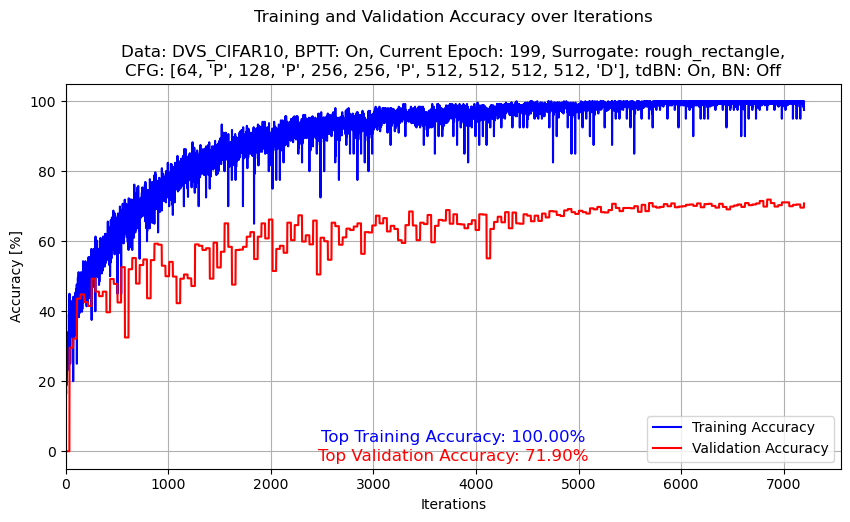

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see most recent train and val acc###########################
train_acc_file_name = 'result_save/train_acc_array.npy'
val_acc_file_name = 'result_save/val_acc_now_array.npy'
hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_train_acc_array = np.load(train_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_train_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_train_acc_array, loaded_val_acc_array)
top_train_acc = hyperparameters['top_train_acc_one_iter']
top_val_acc = hyperparameters['top_val_acc']
which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()